In [1]:
import xarray as xr

In [2]:
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt

In [4]:
import numpy as np

# Aurora
the model make twe steps forecasting

In [5]:
f_root = Path("/discover/nobackup/jli30/qefm-core/qefm/models/src/FMAurora")
ofile1 = "pred_0.nc"
ofile2 = "pred_1.nc"

In [6]:
ds1 = xr.open_dataset((f_root/ofile1))
ds2 = xr.open_dataset((f_root/ofile2))
ds = xr.concat([ds1, ds2], dim="time")

In [7]:
ds

<xarray.Dataset> Size: 597MB
Dimensions:       (time: 2, batch: 1, history: 1, latitude: 720,
                   longitude: 1440, level: 13)
Coordinates:
  * latitude      (latitude) float32 3kB 90.0 89.75 89.5 ... -89.25 -89.5 -89.75
  * longitude     (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time          (time) datetime64[ns] 16B 2025-01-01T12:00:00 2025-01-01T18...
  * level         (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
    rollout_step  (time) int64 16B 1 2
Dimensions without coordinates: batch, history
Data variables:
    surf_2t       (time, batch, history, latitude, longitude) float32 8MB 246...
    surf_10u      (time, batch, history, latitude, longitude) float32 8MB -2....
    surf_10v      (time, batch, history, latitude, longitude) float32 8MB 2.7...
    surf_msl      (time, batch, history, latitude, longitude) float32 8MB 1.0...
    static_z      (time, latitude, longitude) float32 8MB -1.24 ... 2.716e+04
    static_slt    (time, latitude, longitude) float32 8MB 0.0 0.0 ... 1.0 1.0
    static_lsm    (time, latitude, longitude) float32 8MB 0.0 0.0 ... 1.0 1.0
    atmos_t       (time, batch, history, level, latitude, longitude) float32 108MB ...
    atmos_u       (time, batch, history, level, latitude, longitude) float32 108MB ...
    atmos_v       (time, batch, history, level, latitude, longitude) float32 108MB ...
    atmos_q       (time, batch, history, level, latitude, longitude) float32 108MB ...
    atmos_z       (time, batch, history, level, latitude, longitude) float32 108MB ...

In [8]:
era5_root = '/discover/nobackup/jli30/data/Aurora/2025-01-01-surface-level.nc'
dset = xr.open_dataset(era5_root)
dset

<xarray.Dataset> Size: 66MB
Dimensions:     (valid_time: 4, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 32B 2025-01-01 ... 2025-01-01T18:...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 64B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 17MB ...
    u10         (valid_time, latitude, longitude) float32 17MB ...
    v10         (valid_time, latitude, longitude) float32 17MB ...
    msl         (valid_time, latitude, longitude) float32 17MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-08T20:48 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
truth = dset['t2m'].isel(valid_time=2).sel(latitude=slice(90.0, -89.75)).to_numpy().squeeze()
truth.shape

(720, 1440)

In [10]:
pred = ds['surf_2t'].isel(time=0).to_numpy().squeeze()
pred.shape

(720, 1440)

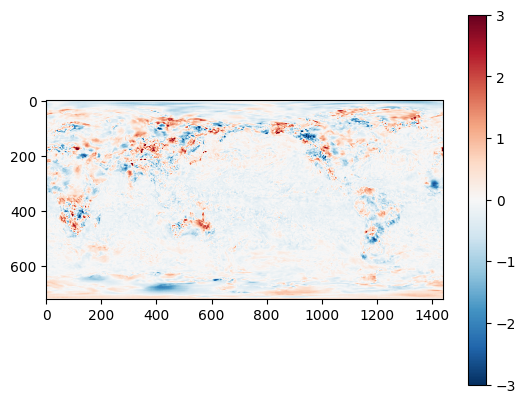

In [23]:
diff = pred-truth
plt.imshow(diff, vmin=-3, vmax=3, cmap='RdBu_r')
plt.colorbar()

In [24]:
diff_flat = diff.flatten()
diff_max = np.ceil(diff_flat.max())
diff_min = np.floor(diff_flat.min())
diff_max, diff_min

(11.0, -7.0)

(array([1.00000e+00, 2.00000e+01, 1.03000e+02, 6.41000e+02, 3.97100e+03,
        2.82400e+04, 5.93625e+05, 3.82299e+05, 2.28860e+04, 4.00500e+03,
        8.04000e+02, 1.54000e+02, 2.60000e+01, 1.30000e+01, 9.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,
         6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 18 artists>)

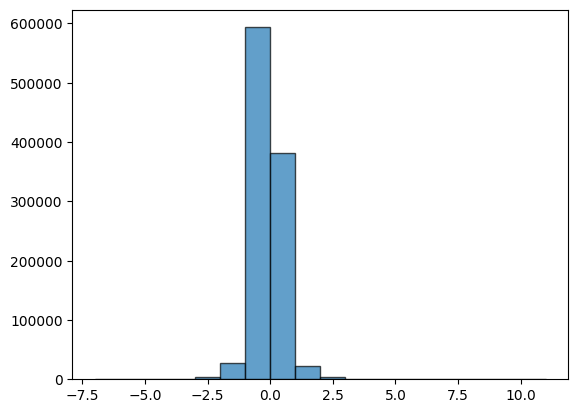

In [27]:
plt.hist(diff_flat, bins=np.arange(diff_min, diff_max+1, 1), edgecolor='black', alpha=0.7)

In [16]:
np.mean(diff)

-0.051515896

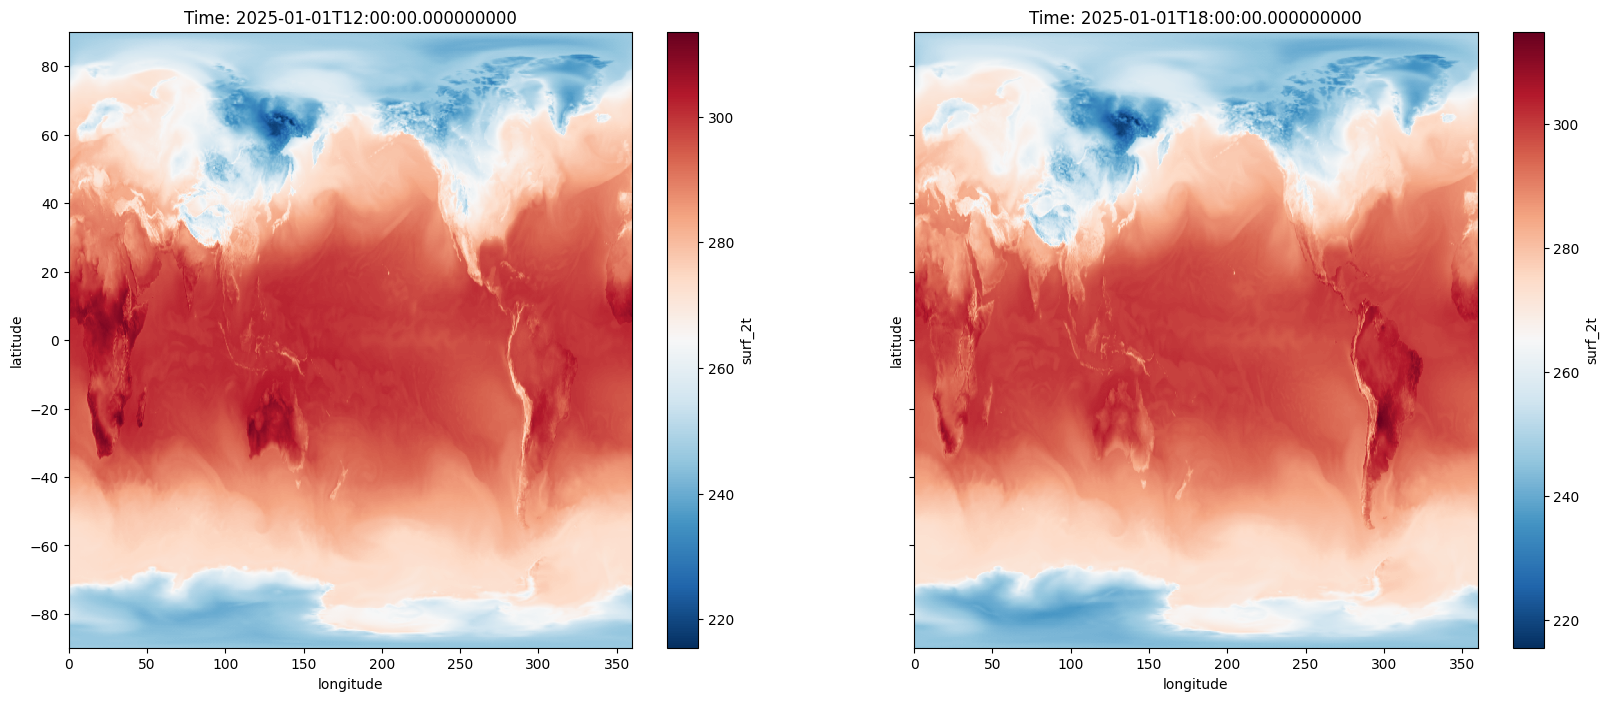

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()
var = "surf_2t"
for i, ax in enumerate(axes):
    ds[var].isel(time=i).squeeze().plot(ax=ax, cmap="RdBu_r")
    ax.set_title(f"Time: {ds.time.values[i]}")

# panggu
using 2015-01-01 00:00 as inputs, making one step forecast with chkpt "pangu_weather_24.onnx" (24-hr lapse?)

Variables:  
        surface -- shaped (4,721,1440); MSLP, U10, V10, T2M **in the exact order**  
        upper   -- shaped (5,13,721,1440); Z, Q, T, U and V **in the exact order**

In [29]:
f_root = Path("/discover/nobackup/jli30/qefm-core/qefm/models/src/FMPangu/Pangu-Weather-pytorch/output_data")
file = "output_surface.npy"

In [30]:
arr = np.load((f_root / file))
arr.shape

(4, 721, 1440)

(-0.5, 1439.5, 720.5, -0.5)

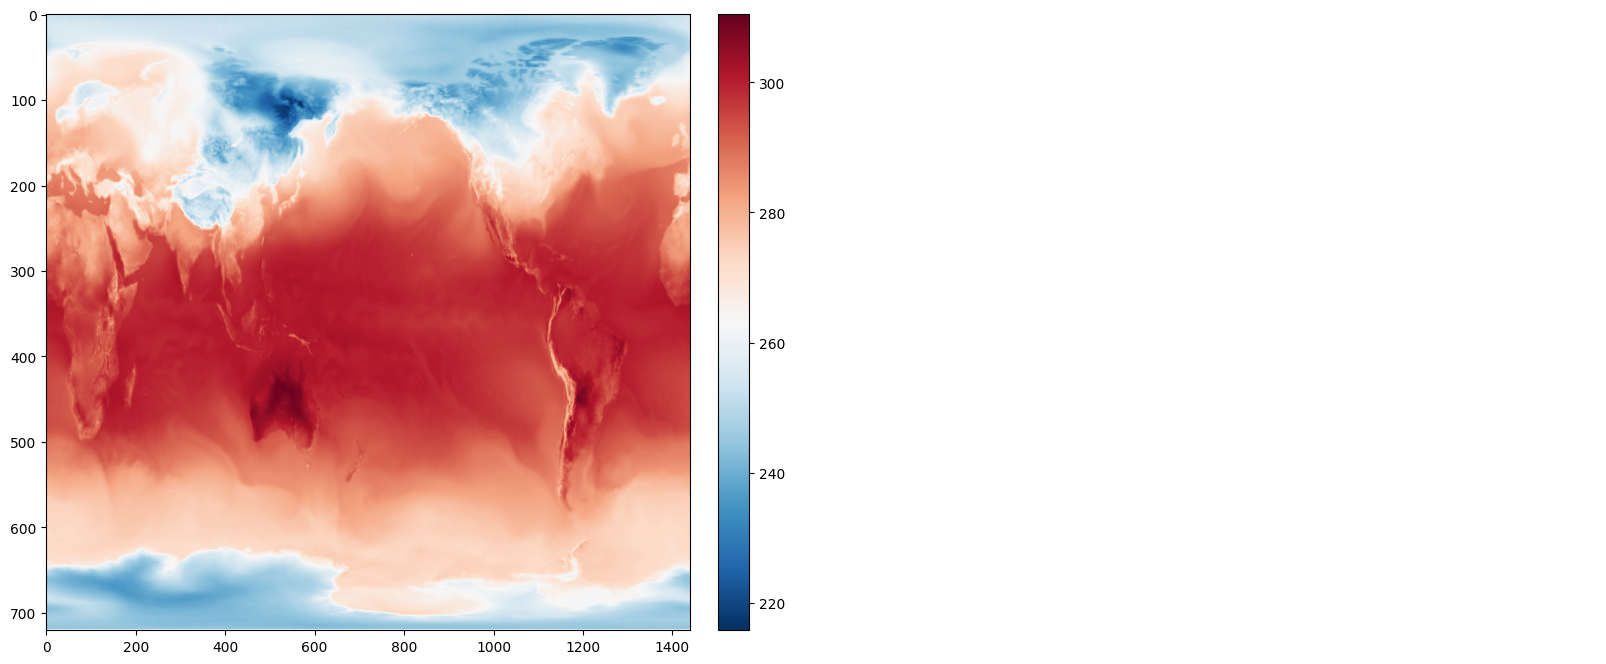

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharex=True, sharey=True)

im = axes[0].imshow(arr[3,...].squeeze(), cmap="RdBu_r", aspect="auto")
cbar = fig.colorbar(im, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.04)

axes[1].axis('off')